In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return image, gray, blurred

In [3]:
def detect_cracks(blurred):
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    kernel = np.ones((3, 3), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    edges_cleaned = cv2.erode(edges_dilated, kernel, iterations=1)
    
    return edges_cleaned

In [4]:
def overlay_cracks(image, edges):
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edges_colored[np.where((edges_colored == [255, 255, 255]).all(axis=2))] = [255, 0, 0] 
    
    overlay = cv2.addWeighted(image, 0.8, edges_colored, 0.5, 0)
    
    return overlay

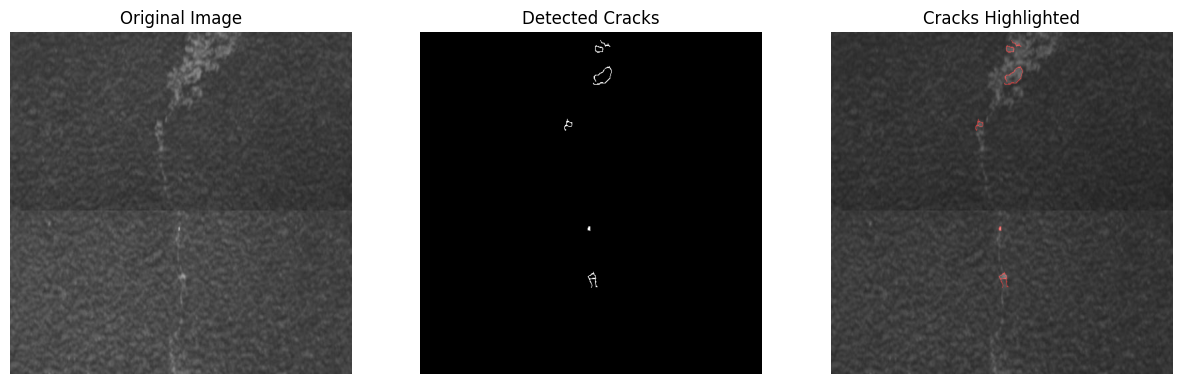

In [8]:
def main():
    image_path = "C:/Users/navee/OneDrive/Desktop/Minor-4/Tunnel Crack Dataset/train/images/train_324_jpg.rf.6e690e1a9f6faf4857f84459d09ad349.jpg"  # Change to your image path
    image, gray, blurred = preprocess_image(image_path)
    edges = detect_cracks(blurred)
    overlay = overlay_cracks(image, edges)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(edges, cmap="gray")
    ax[1].set_title("Detected Cracks")
    ax[1].axis("off")
    
    ax[2].imshow(overlay)
    ax[2].set_title("Cracks Highlighted")
    ax[2].axis("off")
    
    plt.show()

if __name__ == "__main__":
    main()


In [11]:
pip install mrcnn


  Using cached mrcnn-0.2.tar.gz (51 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54919 sha256=7a117eba1144c4f0c2090a84077d08cd06938747747e44f8b01a4628805374ed
  Stored in directory: c:\users\navee\appdata\local\pip\cache\wheels\f6\66\35\4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\navee\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

C:\Users\navee\AppData\Local\Programs\Python\Python310\lib\site-packages\mrcnn\model.py:2337: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':
C:\Users\navee\AppData\Local\Programs\Python\Python310\lib\site-packages\mrcnn\model.py:2337: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


AttributeError: module 'keras.engine' has no attribute 'Layer'

In [12]:
def polygon_to_mask(image_shape, polygon):
    mask = np.zeros(image_shape, dtype=np.uint8)
    polygon = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(mask, [polygon], 1)
    return mask

In [13]:
def load_dataset(image_size=(256, 256)):
    train_images, train_masks = [], []
    
    train_image_dir = r"C:\Users\navee\OneDrive\Desktop\Minor-4\Concrete Cracks\train\images"
    train_mask_dir = r"C:\Users\navee\OneDrive\Desktop\Minor-4\Concrete Cracks\train\labels"
    
    if not os.path.exists(train_image_dir) or not os.path.exists(train_mask_dir):
        raise FileNotFoundError("Dataset directory not found.")
    
    for file in os.listdir(train_image_dir):
        img = img_to_array(load_img(os.path.join(train_image_dir, file), target_size=image_size)) / 255.0
        mask_file = os.path.join(train_mask_dir, file.replace('.jpg', '.json'))
        if os.path.exists(mask_file):
            with open(mask_file, 'r') as f:
                polygons = json.load(f)
            mask = np.zeros(image_size, dtype=np.uint8)
            for polygon in polygons:
                poly = [(int(p[0] * image_size[0]), int(p[1] * image_size[1])) for p in polygon]
                mask = polygon_to_mask(image_size, poly)
        else:
            mask = np.zeros(image_size, dtype=np.uint8)
        
        train_images.append(img)
        train_masks.append(mask)
    
    return np.array(train_images), np.array(train_masks)


In [14]:
def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    u3 = UpSampling2D((2, 2))(c4)
    merge3 = Concatenate()([u3, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge3)
    u2 = UpSampling2D((2, 2))(c5)
    merge2 = Concatenate()([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
    u1 = UpSampling2D((2, 2))(c6)
    merge1 = Concatenate()([u1, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    return Model(inputs, outputs)


In [ ]:
class CrackConfig(Config):
    NAME = "crack_detection"
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 1  # Background + Crack
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2
    )
    image = datagen.random_transform(image)
    return image, gray, blurred

train_images, train_masks = load_dataset()
train_images = np.array(train_images).reshape((-1, 256, 256, 3))
train_masks = np.array(train_masks).reshape((-1, 256, 256, 1))

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)
train_generator = datagen.flow(train_images, train_masks, batch_size=8)

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

unet_model.fit(train_generator, epochs=20, steps_per_epoch=len(train_images) // 8, callbacks=[early_stopping])

config = CrackConfig()
mask_rcnn = MaskRCNN(mode="training", config=config, model_dir="./")
mask_rcnn.keras_model.summary()


In [ ]:
def test_model(image):
    unet_output = unet_model.predict(np.expand_dims(image, axis=0))[0]
    refined_output = mask_rcnn.detect([image])[0]
    return unet_output, refined_output

sample_image = train_images[0]
unet_result, mask_rcnn_result = test_model(sample_image)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(unet_result, cmap='gray')
ax[1].set_title("U-Net Segmentation")
ax[1].axis("off")
ax[2].imshow(mask_rcnn_result['masks'][..., 0], cmap='gray')
ax[2].set_title("Mask R-CNN Refinement")
ax[2].axis("off")
plt.show()
